In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

/home/jindol/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jindol/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 모델 설계 시, 활용 장비 확인
if torch.cuda.is_available:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 2.6.0+cu124 Device: cuda


In [3]:
# CIFAR10 데이터 다운로드
train_dataset = datasets.CIFAR10(root = './CIFAR_10',
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = './CIFAR_10',
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45098037..0.54509807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.7176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clip

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


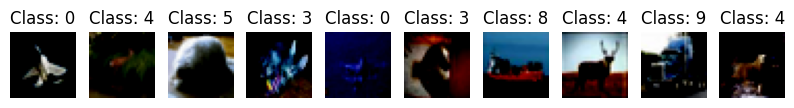

In [4]:
# 데이터 확인

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [5]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 8,
            kernel_size = 3,
            padding = 1)
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = 3,
            padding = 1)
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, X):
        x = self.conv1(X)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x
    

# ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size = 3,
                               stride = stride,
                               padding = 1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1,
                               bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size = 1,
                          stride = stride,
                          bias = False),
                          nn.BatchNorm2d(planes))
    def forward(self, X):
        out = F.relu(self.bn1(self.conv1(X)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(X)
        out = F.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, X):
        out = F.relu(self.bn1(self.conv1(X)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
# Optimizer, objective Function 설정

model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [7]:
# 모델 학습을 진행하며 학습 데이터에 대한 모델 성능 확인하는 함수 정의

def train(model, train_loader, optimizer, log_interval):
    model.train()
    running_loss = 0.0

    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()
        output = model(image)
        loss = F.cross_entropy(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch [{batch_idx * len(image)}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.6f}")

    avg_loss = running_loss / len(train_loader)
    return avg_loss


# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능 확인하는 함수 정의

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 시각화
# 손실, 정확도 기록용 리스트
train_losses = []
test_losses = []
test_accuracies = []

# 학습 실행하며 Train, test set의 Loss 및 Test set Accuracy 확인
for Epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"[EPOCH: {Epoch}] Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Train Epoch [0/50000] Loss: 2.501802
Train Epoch [6400/50000] Loss: 1.477600
Train Epoch [12800/50000] Loss: 1.436583
Train Epoch [19200/50000] Loss: 1.267040
Train Epoch [25600/50000] Loss: 1.138405
Train Epoch [32000/50000] Loss: 1.294513
Train Epoch [38400/50000] Loss: 1.037874
Train Epoch [44800/50000] Loss: 0.968802
[EPOCH: 1] Train Loss: 1.3016, Test Loss: 0.0331, Test Accuracy: 62.19%
Train Epoch [0/50000] Loss: 0.869211
Train Epoch [6400/50000] Loss: 0.844654
Train Epoch [12800/50000] Loss: 1.171828
Train Epoch [19200/50000] Loss: 0.820141
Train Epoch [25600/50000] Loss: 0.699882
Train Epoch [32000/50000] Loss: 0.955623
Train Epoch [38400/50000] Loss: 1.102269
Train Epoch [44800/50000] Loss: 0.622070
[EPOCH: 2] Train Loss: 0.9210, Test Loss: 0.0279, Test Accuracy: 67.93%
Train Epoch [0/50000] Loss: 0.791713
Train Epoch [6400/50000] Loss: 0.796698
Train Epoch [12800/50000] Loss: 0.798186
Train Epoch [19200/50000] Loss: 1.012247
Train Epoch [25600/50000] Loss: 0.674787
Train Epoc

시각화

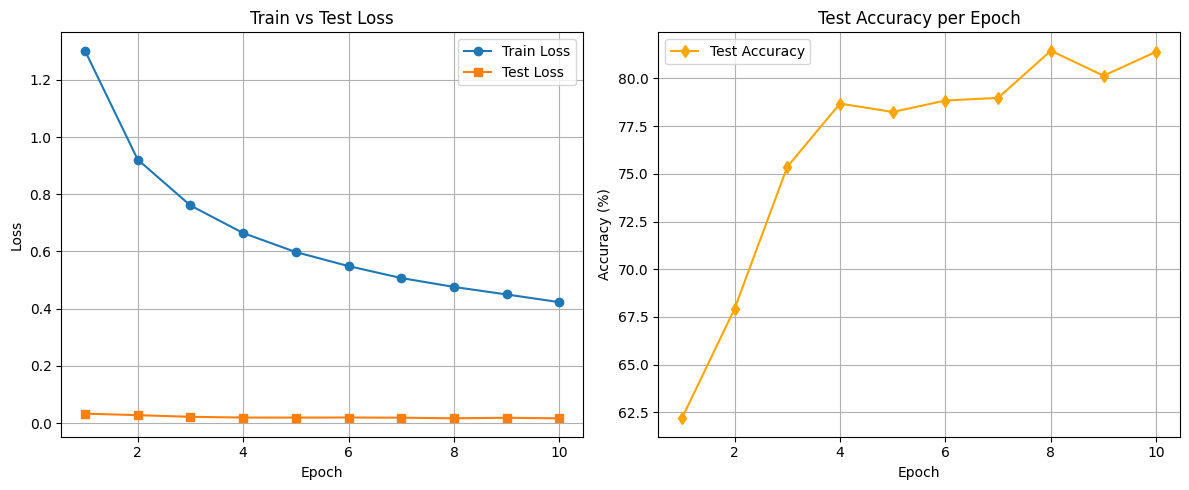

In [8]:
plt.figure(figsize=(12,5))

# 손실 비교
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), test_losses, marker='s', label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도
plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), test_accuracies, marker='d', color='orange', label='Test Accuracy')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
